# Data analysis

In [2]:
import os
import sys
import zipfile
from tqdm import tqdm

from sklearn.manifold import TSNE
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision.models import Swin_T_Weights
import numpy as np
import matplotlib.pyplot as plt
import PIL
import pickle
import torch
import yaml

In [3]:
root_dir = "/home/data/lda/ybt1_2/spoofing_faces_classifier/"
data_dir = os.path.join(root_dir, "data")

In [4]:
train_img_dir = os.path.join(data_dir, "train_img")
train_img_paths = os.listdir(train_img_dir)

In [5]:
sys.path.append(root_dir)
sys.path.append("/home/data/lda/ybt1_2/")

In [6]:
from src.dataset import ImageDataset
from src.model import SpoofingFaceClassifier
from src.train import train
from src.utils import add_attr_interface

## Raw Images

Opening /home/data/lda/ybt1_2/spoofing_faces_classifier/data/train_img/039083.jpg...

Image shape: (64, 64, 3)


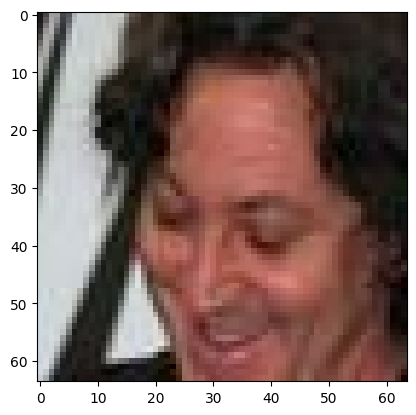

In [7]:
IMG_IDX = np.random.randint(len(train_img_paths))

filepath = os.path.join(train_img_dir, f"{IMG_IDX:06d}.jpg")
print(f"Opening {filepath}...\n")

img = PIL.Image.open(filepath)
plt.imshow(img)
print(f"Image shape: {np.asarray(img).shape}")

In [7]:
train_img_paths = [os.path.join(train_img_dir, path) for i, path in enumerate(train_img_paths)]
unique_img_shapes = np.unique([np.asarray(PIL.Image.open(img_path)).shape for img_path in train_img_paths], axis=0)
print(f"Image shapes: {unique_img_shapes}")

Image shapes: [[64 64  3]]


## Labels

In [8]:
label_train_path = os.path.join(data_dir, "label_train.txt")

In [9]:
with open(label_train_path, 'r') as label_train_file:
  train_labels = label_train_file.readlines()
train_labels = [int(line.strip()) for line in train_labels]

In [10]:
print(f"len(train_labels) = {len(train_labels)}")
classes, labels_per_class = np.unique(train_labels, return_counts=True)
print(f"n_classes = ", classes)
print(f"n_labels = ", labels_per_class)

len(train_labels) = 100000
n_classes =  [0 1]
n_labels =  [12102 87898]


## Images along labels

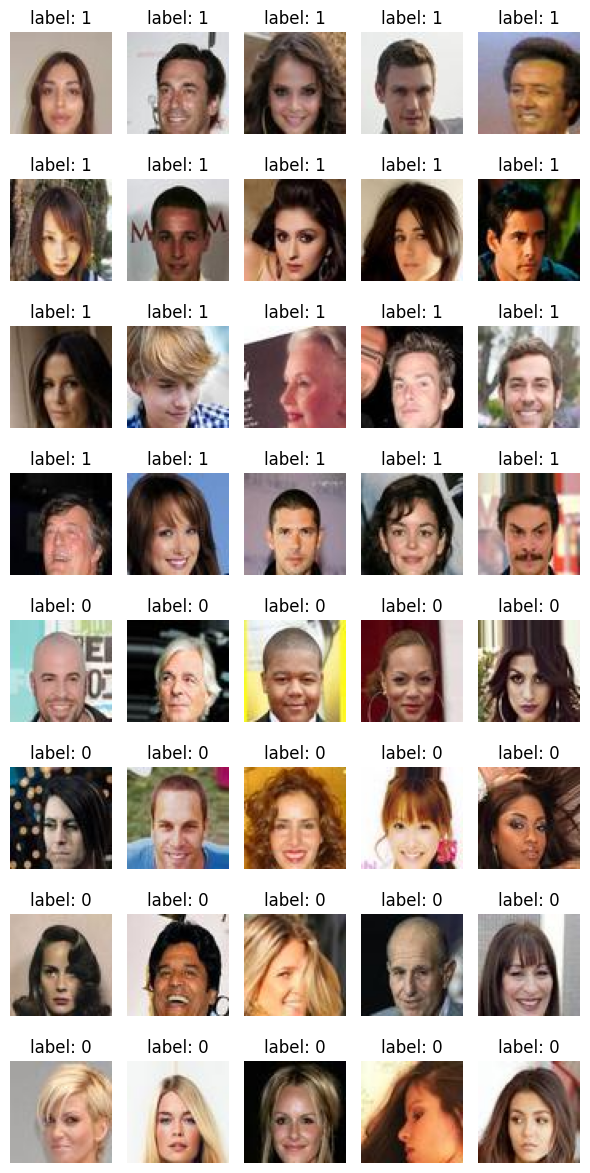

In [10]:
nb_images = 40
rows = 8
cols = 5

assert rows * cols >= nb_images, "nb_images must be smaller than rows * cols"

fig, axes = plt.subplots(rows, cols, figsize=(6,12))

positives = np.where(np.array(train_labels))[0]
negatives = np.where( 1 - np.array(train_labels))[0]

img_pos_indices = np.random.choice(positives, nb_images // 2, replace=False)
img_neg_indices = np.random.choice(negatives, nb_images // 2, replace=False)

img_indices = np.concatenate([img_pos_indices, img_neg_indices], axis=0)

for i, idx in enumerate(img_indices):
    img_filename = f"{idx:06d}.jpg"
    img_path = os.path.join(train_img_dir, img_filename)
    img = PIL.Image.open(img_path)

    row, col = i // cols, i % cols
    axes[row, col].imshow(img)
    axes[row, col].set_title(f"label: {train_labels[idx]}")
    axes[row, col].axis('off')  # Turn off axis

plt.tight_layout()
plt.show()

## Config

In [11]:
cfg_path = os.path.join(root_dir, "config.yml")
output_dir = os.path.join(root_dir, "output")

with open(cfg_path, 'r') as f:
  cfg = add_attr_interface(yaml.safe_load(f))

print(cfg)

{'DATA': {'SEED': 100, 'NB_WORKERS_TRAIN_LOADER': 4, 'NB_WORKERS_VALID_LOADER': 16}, 'MODEL': {'MODEL_TYPE': 'EfficientNet_B0', 'WEIGHTS': 'IMAGENET1K_V1', 'LOSS_TYPE': 'SmoothedHTERLoss', 'ALPHA': 0.6}, 'TRAINING': {'BATCH_SIZE': 512, 'LEARNING_RATE_INIT': 0.0001, 'LEARNING_RATE_SCHEDULER_FACTOR': 0.99, 'WEIGHT_DECAY': 1e-05, 'SEED': 100, 'MAX_EPOCHS': 50, 'VALIDATION_SPLIT': 0.8, 'USE_AMP': True, 'MAX_GRADIENT_VALUE': 1.0, 'SAVE_ALL_MODELS': True, 'MODEL_SAVE_PERIOD': 1, 'COMPUTE_VALIDATION_METRICS_PERIOD': 5, 'USE_DETERMINISTIC_ALGORITHMS': False}}


## Dataset

In [12]:
dataset = ImageDataset(train_img_dir, label_train_path, transform=Swin_T_Weights.IMAGENET1K_V1.transforms())
print("len(dataset) = ", len(dataset))

len(dataset) =  100000


In [13]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f"device = {device}")

device = cuda:1


## Training images histogram analysis

In [16]:
def compute_normalized_histogram(image_path, bins=256):
    image = PIL.Image.open(image_path).convert('L')  # Convert image to grayscale
    histogram, _ = np.histogram(np.array(image).flatten(), bins=bins, range=[0, 256])
    histogram = histogram / np.sum(histogram)  # Normalize the histogram
    return histogram

def compute_fft_magnitude(image_path):
    image = PIL.Image.open(image_path).convert('L')  # Convert image to grayscale
    image_array = np.array(image)
    # Perform FFT and shift zero frequency component to the center
    fft = np.fft.fftshift(np.fft.fft2(image_array))
    # Compute the magnitude spectrum
    magnitude = np.abs(fft)
    magnitude_log = np.log1p(magnitude)  # log(1 + magnitude) to avoid log(0)
    return magnitude_log.flatten()


def compute_mean_histogram_by_label(image_paths_by_label, bins=256, type='intensity'):
    histograms_by_label = {label: [] for label in image_paths_by_label}
    
    for label, image_paths in image_paths_by_label.items():
        for image_path in tqdm(image_paths, desc=f"Processing images for label {label}"):
            if type == "intensity":
                histogram = compute_normalized_histogram(image_path, bins)
            elif type == "fft":
                fft_magnitude = compute_fft_magnitude(image_path)
                histogram, _ = np.histogram(fft_magnitude, bins=bins, range=[0, np.max(fft_magnitude)])
            else:
                raise NotImplementedError
            histograms_by_label[label].append(histogram)
    
    # Compute mean histogram for each label
    mean_histograms_by_label = {
        label: np.mean(histograms, axis=0) for label, histograms in histograms_by_label.items()
    }
    return mean_histograms_by_label

def plot_mean_histogram_comparison(mean_histograms_by_label, bins=256, type='intensity'):
    plt.figure(figsize=(10, 6))
    for label, mean_histogram in mean_histograms_by_label.items():
        plt.plot(range(bins), mean_histogram, label=f'Label: {label}')
    if type == "intensity":
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Normalized Frequency')
    else:
        plt.xlabel('Frequency')
        plt.ylabel('Log(FTT magnitude)')
    plt.title('Mean Histogram by Label')
    plt.legend()
    plt.show()

### Intensity histograms

Processing images for label 1: 100%|██████████████████████████████████████████████████████████████████████████████████| 87898/87898 [00:33<00:00, 2653.61it/s]


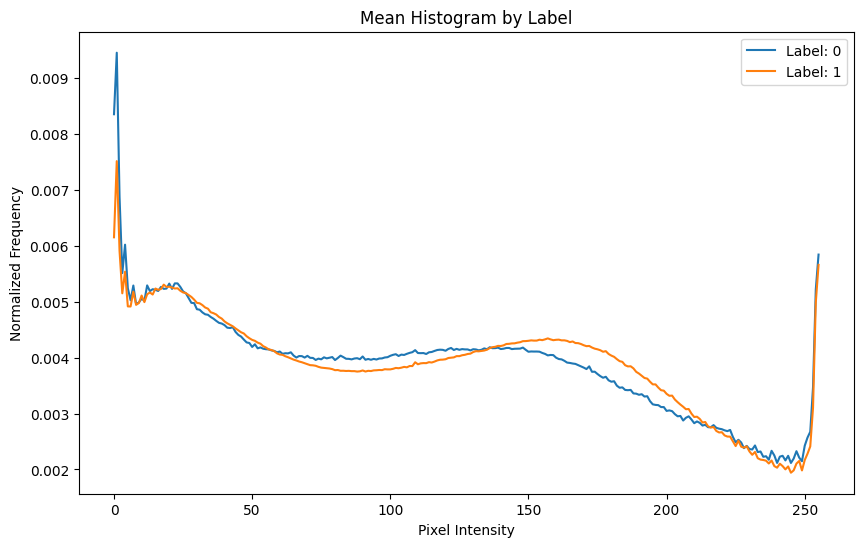

In [16]:
# Load image paths and labels
train_img_paths_by_label = {label: [os.path.join(train_img_dir, path) for i, path in enumerate(train_img_paths) if train_labels[i] == label] for label in np.unique(train_labels)}

# Analyze the images by label
histograms_by_label = compute_mean_histogram_by_label(train_img_paths_by_label, type='intensity')

# Plot the histograms by label
plot_mean_histogram_comparison(histograms_by_label)

### Frequential domain histograms

Processing images for label 1: 100%|██████████████████████████████████████████████████████████████████████████████████| 87898/87898 [00:46<00:00, 1885.29it/s]


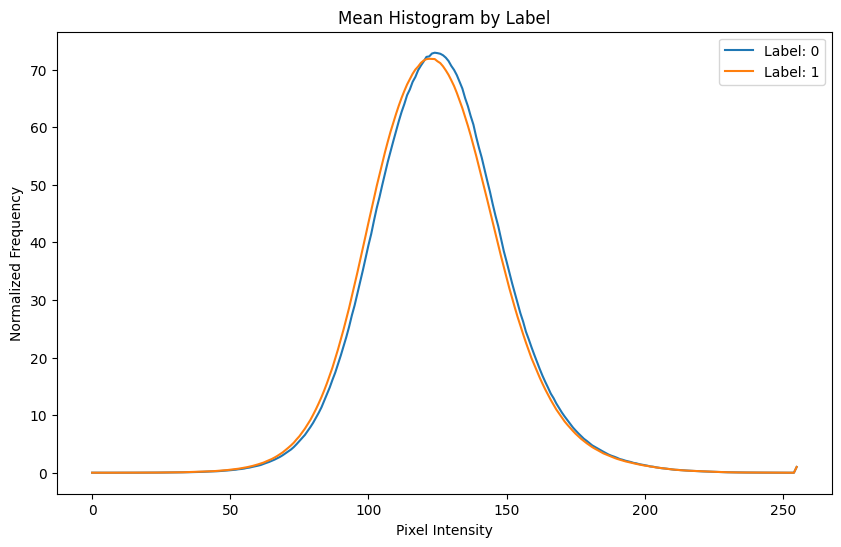

In [17]:
# Analyze the images by label
histograms_by_label = compute_mean_histogram_by_label(train_img_paths_by_label, type='fft')

# Plot the histograms by label
plot_mean_histogram_comparison(histograms_by_label, type='fft)

### Test images histogram analysis

Processing images for label test_images: 100%|████████████████████████████████████████████████████████████████████████| 20000/20000 [00:07<00:00, 2523.88it/s]


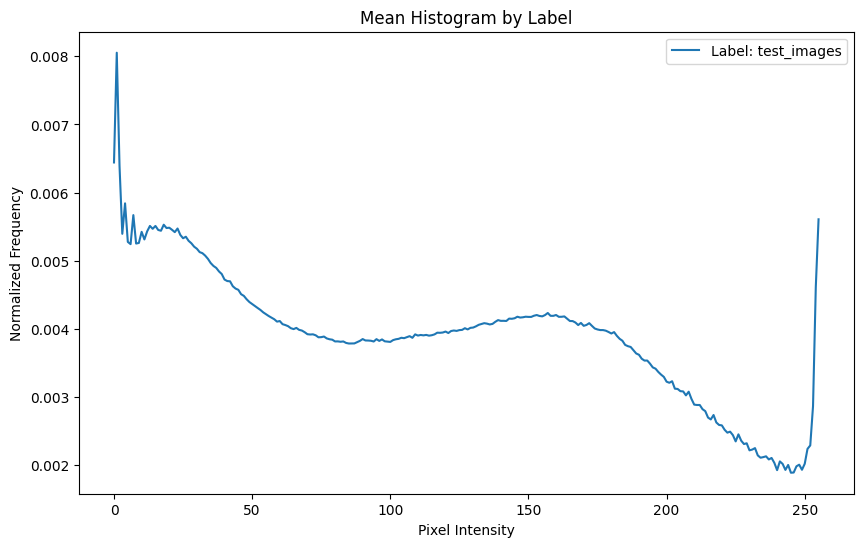

In [18]:
test_img_dir = os.path.join(data_dir, "val_img")
test_img_paths = os.listdir(test_img_dir)

test_img_paths = {'test_images': [os.path.join(test_img_dir, path) for i, path in enumerate(test_img_paths)]}
histograms_test_distrib = compute_mean_histogram_by_label(test_img_paths)
plot_mean_histogram_comparison(histograms_test_distrib)

# Inference results

### Trained model loading

In [14]:
# loading trained model
MODEL_NAME = "2024_08_30-22h13_EfficientNet_B0_HTER/models/model_epoch_13.pth"
output_dir = os.path.join(root_dir, "output")
model_path = os.path.join(output_dir, MODEL_NAME)

model = SpoofingFaceClassifier.from_trained_torch_model(model_path, device)

In [15]:
# Load split file
split_path = os.path.join(output_dir, "dataset_split.pkl")
with open(split_path, 'rb') as pickle_file:
    split = pickle.load(pickle_file)
val_indices = split['val_indices']

### Inference on one image with 

Image n°48610
Image shape: (64, 64, 3)
prob =  1.000
predicted label = 1
ground-truth = 1


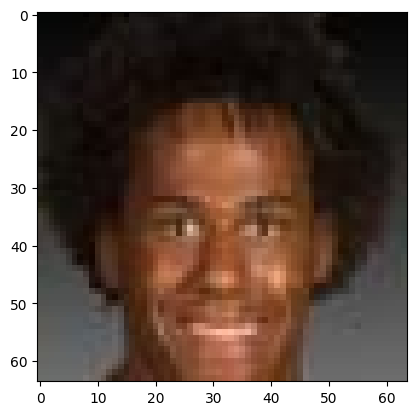

In [33]:
# Get validation image
img_idx = np.random.choice(val_indices)
print(f"Image n°{img_idx}")

filepath = os.path.join(train_img_dir, f"{img_idx:06d}.jpg")
img = PIL.Image.open(filepath)
plt.imshow(img)
print(f"Image shape: {np.asarray(img).shape}")

# Infer on chosen image
img = torch.from_numpy(np.ascontiguousarray(img).transpose((2, 0, 1))).to(torch.float)
preprocessed_image = dataset.transform(img).unsqueeze(0).to(device)
logits = model(preprocessed_image).squeeze()
prob = torch.sigmoid(logits)
print(f"prob = {prob.item(): .3f}")
print(f"predicted label = {int(prob > 0.5)}")
print(f"ground-truth = {int(dataset.labels[img_idx])}")

In [36]:
# Instantiate validation set dataloader
val_dataset = Subset(dataset, val_indices)
val_loader = DataLoader(val_dataset, cfg.TRAINING.BATCH_SIZE, num_workers=cfg.DATA.NB_WORKERS_VALID_LOADER)

In [37]:
from src.model import compute_hter_metric

val_losses = 0
preds, probs, targets = [], [], []
model.eval()  # Switch to model eval mode
for i_batch, (batch, labels) in enumerate(val_loader):
    batch = batch.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        logits = model(batch).squeeze()
        preds.append(logits.squeeze())
        targets.append(labels)
        print(f"batch {i_batch + 1}/{len(val_loader)}")

preds = torch.cat(preds).cpu()
probs = torch.sigmoid(preds)
classes = (probs > 0.5).int()
targets = torch.cat(targets).int().cpu()

hter = compute_hter_metric(preds, targets)

print(f"HTER = {hter.item()}")

batch 1/40
batch 2/40
batch 3/40
batch 4/40
batch 5/40
batch 6/40
batch 7/40
batch 8/40
batch 9/40
batch 10/40
batch 11/40
batch 12/40
batch 13/40
batch 14/40
batch 15/40
batch 16/40
batch 17/40
batch 18/40
batch 19/40
batch 20/40
batch 21/40
batch 22/40
batch 23/40
batch 24/40
batch 25/40
batch 26/40
batch 27/40
batch 28/40
batch 29/40
batch 30/40
batch 31/40
batch 32/40
batch 33/40
batch 34/40
batch 35/40
batch 36/40
batch 37/40
batch 38/40
batch 39/40
batch 40/40
HTER =  tensor(0.0883)


In [38]:
indices_pos = torch.where(targets)[0]
indices_neg = torch.where(1 - targets)[0]
diff_pos = targets[indices_pos].int() - classes[indices_pos].int()
diff_neg = targets[indices_neg].int() - classes[indices_neg].int()
print(f"error rate positives = {(diff_pos != 0).sum()}/{len(indices_pos)}")
print(f"error rate negatives = {(diff_neg != 0).sum()}/{len(indices_neg)}")

print(f"proba for 1-labeled image: mean={probs[indices_pos].mean(): .3f}, std={probs[indices_pos].std(): .3f}")
print(f"proba for 0-labeled image: mean={probs[indices_neg].mean(): .3f}, std={probs[indices_neg].std(): .3f}")

error rate positives = 1806/17580
error rate negatives = 179/2420
proba for 1-labeled image: mean= 0.897, std= 0.299
proba for 0-labeled image: mean= 0.074, std= 0.255


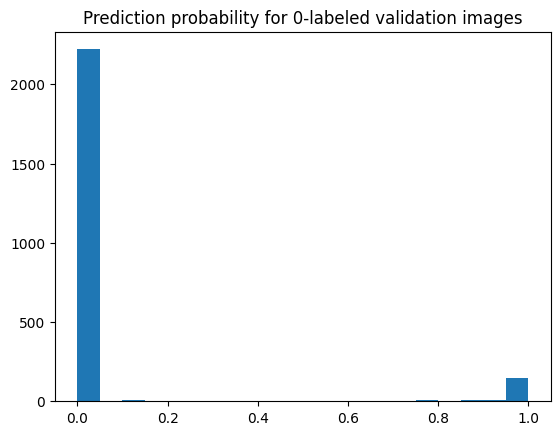

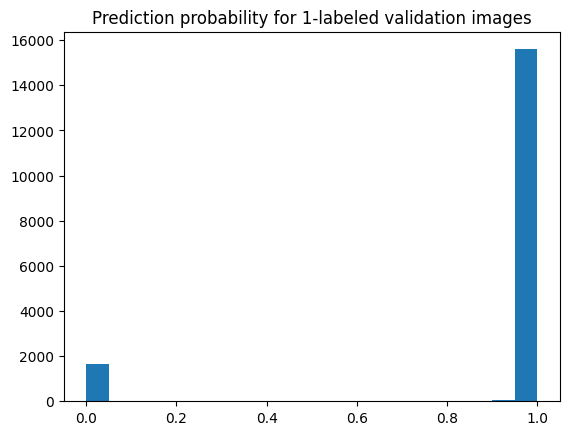

In [39]:
plt.hist(probs[indices_neg], bins=20)
plt.title("Prediction probability for 0-labeled validation images")
plt.show()

plt.hist(probs[indices_pos], bins=20)
plt.title("Prediction probability for 1-labeled validation images")
plt.show()

### t-SNE visualization on trained model's latent vectors

In [40]:
# remove head layers to have access to latent vectors (remove Flatten, & Linear)
truncated_model = model.model.backbone

### Get features on validation samples

In [41]:
# Instantiate validation set dataloader
val_dataset = Subset(dataset, val_indices)
val_loader = DataLoader(val_dataset, cfg.TRAINING.BATCH_SIZE, num_workers=cfg.DATA.NB_WORKERS_VALID_LOADER)

features = []
labels = []

with torch.no_grad():
    for i, (batch, targets) in enumerate(val_loader):
        batch = batch.to(device)
        output = truncated_model(batch)
        features.append(output.cpu().numpy())
        labels.append(targets.numpy())
        print(f"Processed batch {i}/{len(val_loader)}")

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

Processed batch 0/40
Processed batch 1/40
Processed batch 2/40
Processed batch 3/40
Processed batch 4/40
Processed batch 5/40
Processed batch 6/40
Processed batch 7/40
Processed batch 8/40
Processed batch 9/40
Processed batch 10/40
Processed batch 11/40
Processed batch 12/40
Processed batch 13/40
Processed batch 14/40
Processed batch 15/40
Processed batch 16/40
Processed batch 17/40
Processed batch 18/40
Processed batch 19/40
Processed batch 20/40
Processed batch 21/40
Processed batch 22/40
Processed batch 23/40
Processed batch 24/40
Processed batch 25/40
Processed batch 26/40
Processed batch 27/40
Processed batch 28/40
Processed batch 29/40
Processed batch 30/40
Processed batch 31/40
Processed batch 32/40
Processed batch 33/40
Processed batch 34/40
Processed batch 35/40
Processed batch 36/40
Processed batch 37/40
Processed batch 38/40
Processed batch 39/40


In [42]:
features.shape

(20000, 1280, 1, 1)

In [1]:
# Fitting t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features.reshape(features.shape[0], -1))

NameError: name 'TSNE' is not defined

In [ ]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title("t-SNE on model's feature maps")
plt.show()